In [39]:
import seaborn as sns
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
# import pytorch_lightning as pl


from transformers import (
    AdamW,
    AutoTokenizer,
    RobertaTokenizerFast,
    T5ForConditionalGeneration,
    T5TokenizerFast,
    AutoTokenizer,
    PreTrainedTokenizerFast,
    T5ForTokenClassification,
    RobertaTokenizerFast,
    AutoModelForTokenClassification,
    get_linear_schedule_with_warmup
)

label2id = {'O': 0, 'B-ALG': 1, 'I-ALG': 2, 'B-APP': 3, 'I-APP': 4, 'B-CB': 5, 'I-CB': 6, 'B-CLA': 7, 'I-CLA': 8, 'B-DEV': 9, 'I-DEV': 10, 'B-DS': 11, 'I-DS': 12, 'B-DT': 13, 'I-DT': 14, 'B-FN': 15, 'I-FN': 16, 'B-FT': 17, 'I-FT': 18, 'B-FUN': 19, 'I-FUN': 20, 'B-HXT': 21, 'I-HXT': 22, 'B-LAN': 23, 'I-LAN': 24, 'B-LIB': 25, 'I-LIB': 26, 'B-OS': 27, 'I-OS': 28, 'B-UIE': 29, 'I-UIE': 30, 'B-UN': 31, 'I-UN': 32, 'B-VAL': 33, 'I-VAL': 34, 'B-VAR': 35, 'I-VAR': 36, 'B-VER': 37, 'I-VER': 38, 'B-WEB': 39, 'I-WEB': 40, "PAD": -100}
id2label = {label2id[x]: x for x in label2id}
labels = ['Algorithm', 'Application', 'Class', 'Code_Block', 'Data_Structure', 'Data_Type', 'Device', 'File_Name', 'File_Type', 'Function', 'HTML_XML_Tag', 'Language', 'Library', 'Operating_System', 'User_Interface_Element', 'User_Name', 'Value', 'Variable', 'Version', 'Website']
labels_short = ['ALG', 'APP', 'CB', 'CLA', 'DEV', 'DS', 'DT', 'FN', 'FT', 'FUN', 'HXT', 'LAN', 'LIB', 'OS', 'UIE', 'UN', 'VAL', 'VAR', 'VER', 'WEB']
short2long = {'ALG': 'Algorithm', 'APP': 'Application', 'CB': 'Class', 'CLA': 'Code_Block', 'DEV': 'Data_Structure', 'DS': 'Data_Type', 'DT': 'Device', 'FN': 'File_Name', 'FT': 'File_Type', 'FUN': 'Function', 'HXT': 'HTML_XML_Tag', 'LAN': 'Language', 'LIB': 'Library', 'OS': 'Operating_System', 'UIE': 'User_Interface_Element', 'UN': 'User_Name', 'VAL': 'Value', 'VAR': 'Variable', 'VER': 'Version', 'WEB': 'Website'}
path_save_image = "../figs/plot_baseline_clf_base_"

from datasets import load_dataset
import datasets
datasets.builder.has_sufficient_disk_space = lambda needed_bytes, directory='.': True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abuboba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
path = "../data/StackOverflow/json/"

dataset = load_dataset('json', data_files=os.path.join(path, 'data_train.json'))
dataset["test"] = load_dataset('json', data_files=os.path.join(path, 'data_test.json'))["train"]
dataset["validation"] = load_dataset('json', data_files=os.path.join(path, 'data_dev.json'))["train"]


In [3]:
model_code_name = "microsoft/codebert-base"
tokenizer_code = RobertaTokenizerFast.from_pretrained(model_code_name, add_prefix_space=True)
model_code = AutoModelForTokenClassification.from_pretrained(
    "../checkpoints/codebert-base-token-clf/checkpoint-11580", num_labels=len(label2id), id2label=id2label, label2id=label2id, device_map='cuda:0'
)

model_name = "FacebookAI/roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_name, add_prefix_space=True)
model = AutoModelForTokenClassification.from_pretrained(
    "../checkpoints/roberta-base-token-clf/checkpoint-11580", num_labels=len(label2id), id2label=id2label, label2id=label2id, device_map='cuda:0'
)#.to("cuda")

In [4]:
def tokenize_and_align_labels(examples, tokenizer):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True, fn_kwargs={"tokenizer": tokenizer})
tokenized_dataset_code = dataset.map(tokenize_and_align_labels, batched=True, fn_kwargs={"tokenizer": tokenizer_code})

Map:   0%|          | 0/2936 [00:00<?, ? examples/s]

Map:   0%|          | 0/2936 [00:00<?, ? examples/s]

In [53]:
from tqdm import tqdm

pred = []
pred_code, true_code = [], []
# for item in tokenized_dataset["validation"]:
#     a = tokenizer(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
#     predictions = np.argmax(model(**a).logits.cpu().detach(), axis=2)
#     pred.extend(predictions)
    # print(compute_metrics((model(**a).logits.cpu().detach(), tokenized_dataset["test"]["labels"]), full=True))

label_list = list(label2id.keys())

for item in tqdm(tokenized_dataset_code["validation"]):
    a = tokenizer_code(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
    predictions = np.argmax(model_code(**a).logits.cpu().detach(), axis=2)
    labels = [item['labels']]
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    pred_code.extend(true_predictions)
    # print(len(item['labels']), len([x.item() for x in list(predictions[0])]), [x.item() for x in list(predictions[0])])
    true_code.extend(true_labels)

100%|██████████| 2936/2936 [00:21<00:00, 134.90it/s]


In [32]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels



def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots(figsize =(20, 20))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization


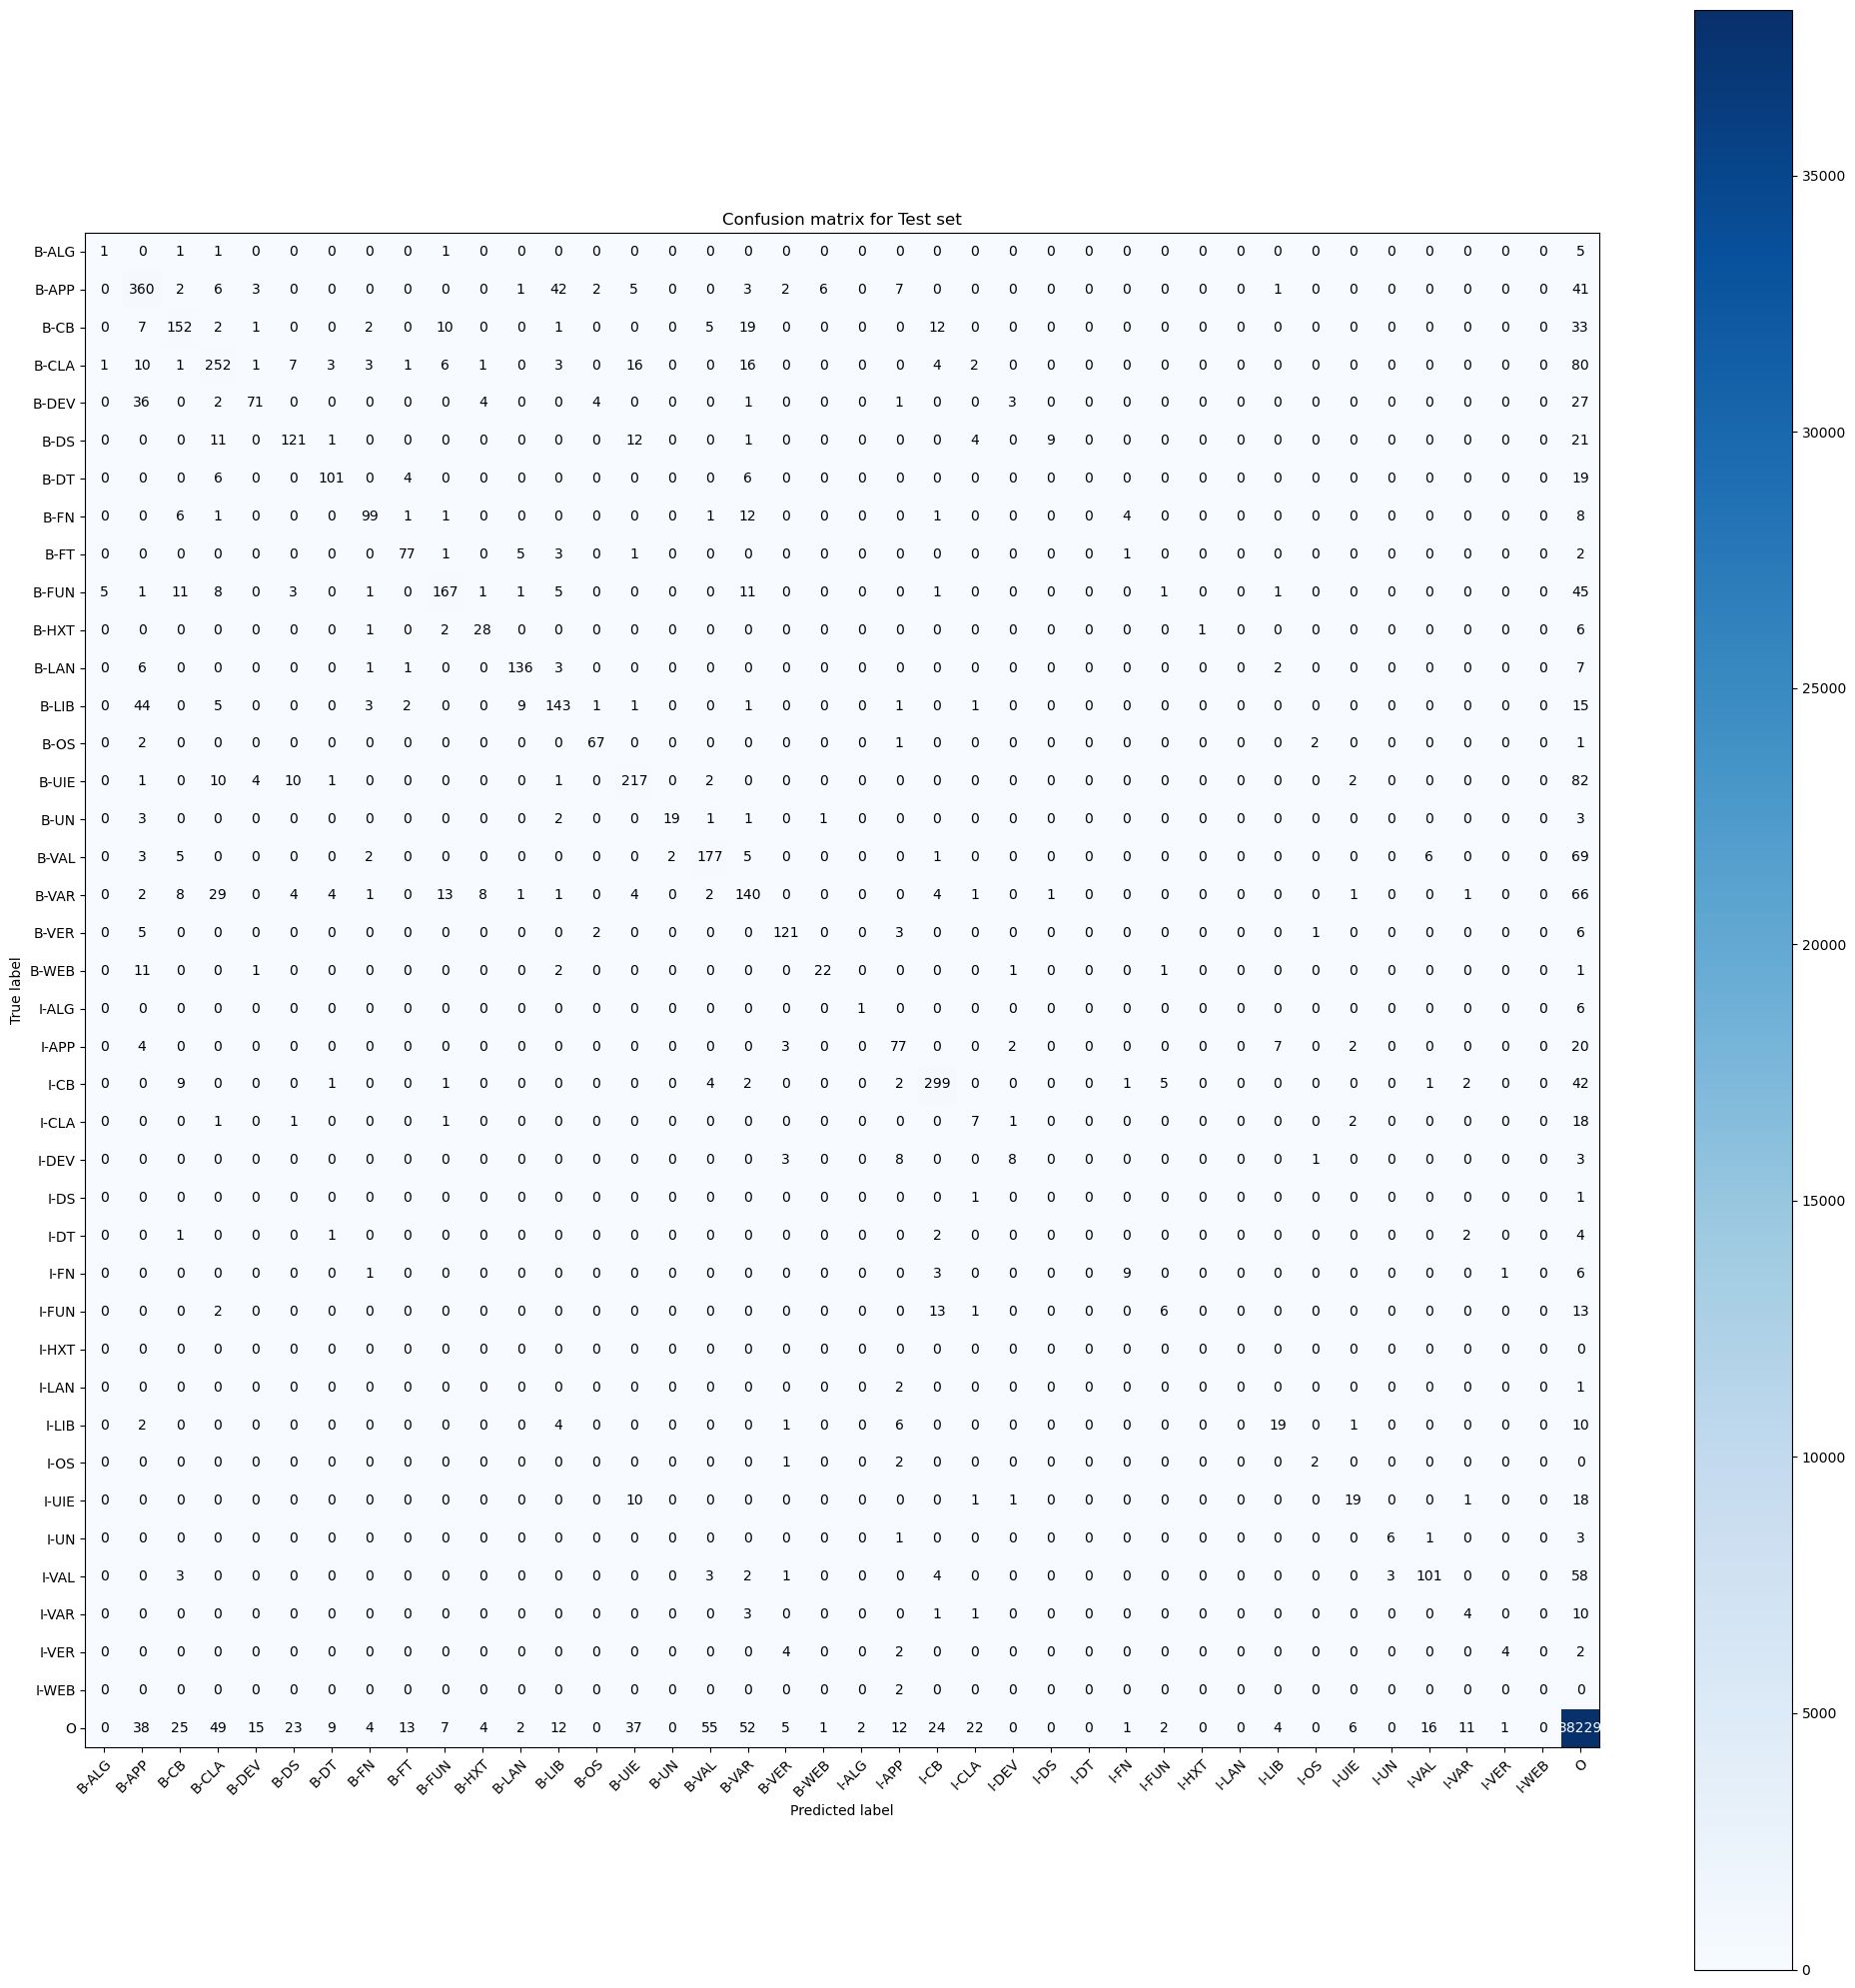

In [55]:

conf_true_val = []
for x in true_code:
    conf_true_val.extend(x)

conf_pred_val = []
for x in pred_code:
    conf_pred_val.extend(x)

plot_confusion_matrix(conf_true_val, conf_pred_val, classes=labels_short,
                      title='Confusion matrix for Test set')
plt.show()